## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


## Loading the Dataset

In [ ]:
# Load the dataset
data = pd.read_csv('HPQ.csv')

# Display the first few rows
print("Dataset Preview:")
print(data.head())

# Display basic information
print("\nDataset Info:")
data.info()


## Data Preprocessing

                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
1962-01-02  0.131273  0.131273  0.124177  0.124177   0.006887  2480300
1962-01-03  0.124177  0.124177  0.121516  0.122846   0.006813   507300
1962-01-04  0.122846  0.126838  0.117968  0.120185   0.006666   845500
1962-01-05  0.119742  0.119742  0.117525  0.117525   0.006518   338200
1962-01-08  0.117525  0.119299  0.115307  0.119299   0.006617   873700


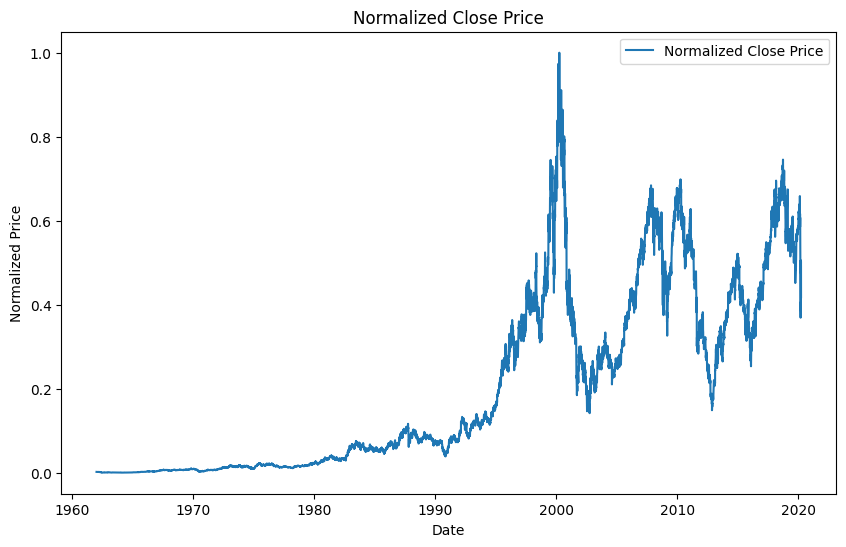

In [4]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Display the data after setting the index
print(data.head())

# Select the 'Close' column for forecasting
close_data = data['Close'].values.reshape(-1, 1)

# Normalize the 'Close' prices using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(data.index, scaled_data, label='Normalized Close Price')
plt.title("Normalized Close Price")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()


## Creating Sequences for Training and Testing
To train an RNN, we need to convert the time series data into sequences. We'll create input sequences of a given length (e.g., 60 days) and their corresponding output (the price for the next day).

In [ ]:
# Function to create sequences from the time series data
def create_sequences(data, sequence_length):
    X = []
    y = []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i, 0])  # Input sequence
        y.append(data[i, 0])  # Output value (next day's price)
    
    return np.array(X), np.array(y)

# Define the sequence length
sequence_length = 60  # Use 60 days of data to predict the next day's price

# Create sequences for training
X, y = create_sequences(scaled_data, sequence_length)

# Reshape X to be compatible with LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check the shape of the input data
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


## Building the LSTM Model
 let's build a simple LSTM model to forecast the stock prices.

In [ ]:
# Build the LSTM model
model = Sequential()

# Add LSTM layer with 50 units and return sequences
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Add Dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add another LSTM layer
model.add(LSTM(units=50, return_sequences=False))

# Add Dropout layer
model.add(Dropout(0.2))

# Add the output layer with a single neuron
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Display the model summary
model.summary()


## Training the Model
let's train the LSTM model on the training data.

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


## Model Evaluation
Now that the model is trained, let's evaluate its performance on the test set and plot the predictions.

Root Mean Squared Error (RMSE): 0.7888092913513833
Mean Absolute Error (MAE): 0.6058026020939642


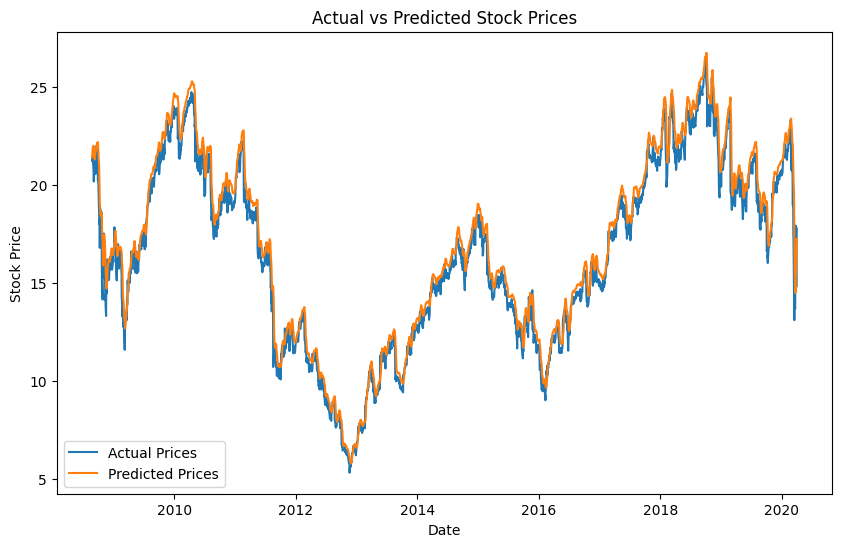

In [9]:
# Predict on the test data
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values to the original scale
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics (RMSE and MAE)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

# Plot actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.plot(data.index[train_size+sequence_length:], y_test_rescaled, label='Actual Prices')
plt.plot(data.index[train_size+sequence_length:], y_pred_rescaled, label='Predicted Prices')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


## Hyperparameter Tuning and Regularization (Optional)
In this step, we can tune the model’s hyperparameters and apply additional regularization techniques to improve performance.

In [ ]:
# Hyperparameter tuning - You can experiment with different batch sizes, sequence lengths, and units.
# For example, let's try increasing the number of LSTM units or changing dropout rate:

# Build the optimized LSTM model
optimized_model = Sequential()

# Add LSTM layer with increased units and different dropout rate
optimized_model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
optimized_model.add(Dropout(0.3))  # Increased dropout rate

# Add another LSTM layer with increased units
optimized_model.add(LSTM(units=100, return_sequences=False))
optimized_model.add(Dropout(0.3))

# Output layer
optimized_model.add(Dense(units=1))

# Compile the model with a different optimizer and learning rate
optimized_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the optimized model
optimized_history = optimized_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the loss for the optimized model
plt.figure(figsize=(10, 6))
plt.plot(optimized_history.history['loss'], label='Training Loss')
plt.plot(optimized_history.history['val_loss'], label='Validation Loss')
plt.title("Optimized Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate the optimized model
optimized_y_pred = optimized_model.predict(X_test)
optimized_y_pred_rescaled = scaler.inverse_transform(optimized_y_pred)
optimized_y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate RMSE and MAE for optimized model
optimized_rmse = np.sqrt(mean_squared_error(optimized_y_test_rescaled, optimized_y_pred_rescaled))
optimized_mae = mean_absolute_error(optimized_y_test_rescaled, optimized_y_pred_rescaled)

print(f"Optimized Model RMSE: {optimized_rmse}")
print(f"Optimized Model MAE: {optimized_mae}")

# Plot actual vs predicted prices for the optimized model
plt.figure(figsize=(10, 6))
plt.plot(data.index[train_size+sequence_length:], optimized_y_test_rescaled, label='Actual Prices')
plt.plot(data.index[train_size+sequence_length:], optimized_y_pred_rescaled, label='Predicted Prices')
plt.title("Optimized Model: Actual vs Predicted Stock Prices")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


## Model Deployment (Optional)
In this step, we can create a simple function or API to deploy the model and make predictions on new data. For now, let's create a function that allows you to input stock data and get predictions for the next day.

In [ ]:
# Function to make predictions on new data
def predict_stock_price(new_data, model, scaler, sequence_length=60):
    # Preprocess the input data (same as training data preprocessing)
    new_data_scaled = scaler.transform(new_data.reshape(-1, 1))
    
    # Create sequences for prediction
    X_new = []
    X_new.append(new_data_scaled[-sequence_length:])  # Use the last 'sequence_length' data points
    X_new = np.array(X_new)
    
    # Reshape for the LSTM model
    X_new = X_new.reshape(X_new.shape[0], X_new.shape[1], 1)
    
    # Make prediction
    predicted_price = model.predict(X_new)
    
    # Inverse scale the predicted price
    predicted_price_rescaled = scaler.inverse_transform(predicted_price)
    
    return predicted_price_rescaled[0][0]

# Example usage (predict the next day's price using the last 60 days of data)
new_data_example = scaled_data[-60:]  # Using the last 60 days from the dataset as an example
predicted_price = predict_stock_price(new_data_example, optimized_model, scaler)
print(f"Predicted next day's stock price: {predicted_price}")


## Model Save and Load (Optional)
To make the model reusable without retraining, we can save it to disk and load it when needed. This step is useful for deploying the model for production or future use.

In [ ]:
# Save the trained model
optimized_model.save("stock_price_prediction_model.h5")
print("Model saved successfully!")

# Load the saved model (for later use)
from tensorflow.keras.models import load_model
loaded_model = load_model("stock_price_prediction_model.h5")
print("Model loaded successfully!")

# Example: Predict using the loaded model
predicted_price_loaded_model = predict_stock_price(new_data_example, loaded_model, scaler)
print(f"Predicted next day's stock price using the loaded model: {predicted_price_loaded_model}")
